- Original code from Y. Chen

- Modified by Jae Hoon (Daniel) Lee

In [1]:
import torch
import numpy as np
import scipy.integrate
solver = scipy.integrate.solve_ivp
from numpy import sin, cos 
import matplotlib.pyplot as plt
import random


seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True

In [2]:
# parameters
k1 = 3.0
k2 = 5.0
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0

def func_mass_spring_series(t, state):
  """
  ODE of the serial mass-spring system (q, v space)
  state = [q1, q2, v1, v2]
  """
  dvdt = np.zeros_like(state)
  # dq/dt = v
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  # dv/dt = a (acceleration computation)
  dvdt[2] = (-k1*(state[0]-l1) + k2*(state[1]-state[0]-l2)) / m1
  dvdt[3] = -k2*(state[1]-state[0]-l2) / m2
  return dvdt

# the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]
num = 1000

x1_init = np.random.randn(num)
x2_init = np.random.randn(num)
v1_init = np.random.randn(num)
v2_init = np.random.randn(num)
state_init_list = []
for i in range(num):
  s = (x1_init[i], x2_init[i], v1_init[i], v2_init[i]) # keep the order (q1, q2, v1, v2) of the original Y. Chen's
  state_init_list.append(s)

x_input = None
x_target = None
flag = False

for i in range(num):
  sol = solver(func_mass_spring_series, [0, tend], state_init_list[i], t_eval=t_eval)
  tval = sol['t']
  
  # sol['y'] shape is (4, M) : [q1_traj, q2_traj, v1_traj, v2_traj]
  q1 = sol['y'][0, :]
  q2 = sol['y'][1, :]
  v1 = sol['y'][2, :]
  v2 = sol['y'][3, :]

  # 1. Transform (q, v) data intto (q, p) data
  p1 = m1 * v1 # p = m*v
  p2 = m2 * v2
  
  # xval_qp shape: (4, M) - [q1, q2, p1, p2] structure
  xval_qp = np.vstack([q1, q2, p1, p2]) 

  # 2. HNN target (dq/dt, dp/dt) computation
  # a (v_dot) is extracted from the output of func_mass_spring_series()
  dxdt_qv = func_mass_spring_series(tval, sol['y']) # func output shape: (4, M)
  a1 = dxdt_qv[2, :] # a1 = dv1/dt
  a2 = dxdt_qv[3, :] # a2 = dv2/dt

  dp1_dt = m1 * a1 # dp/dt = m*a
  dp2_dt = m2 * a2

  # dxdt_qp shape: (4, M) - [dq1/dt, dq2/dt, dp1/dt, dp2/dt] structure
  dxdt_qp = np.vstack([v1, v2, dp1_dt, dp2_dt]) # dq1/dt=v1, dq2/dt=v2
  
  # Used concatenate logic of the original Y. Chen's (axis=1)
  if flag:
    x_input = np.concatenate([x_input, xval_qp], 1) 
    x_target = np.concatenate([x_target, dxdt_qp], 1)
  else:
    x_input = xval_qp
    x_target = dxdt_qp
    flag = True

# Final shape: (4, M*num)
print('x_input shape:', x_input.shape)
print('x_target shape:', x_target.shape)

# I will take input scale and target scale separately!
x_target_max = np.abs(x_target).max(axis=1)
A = np.diag(x_target_max)
x_input_max = np.abs(x_input).max(axis=1)
B = np.diag(x_input_max) # Now B differs from A

print('A matrix:\n', A)
print('B matrix:\n', B)

x_target_scaled = np.linalg.inv(A)@x_target
x_input_scaled = np.linalg.inv(B)@x_input

# add _ms_series_qp to filename and save (.T is applied, so we have (M*num, 4) shape)
intput_file = np.savetxt("hnn_input_ms_qp_sep_sc.csv", x_input_scaled.T, delimiter=',')
target_file = np.savetxt("hnn_target_ms_qp_sep_sc.csv", x_target_scaled.T, delimiter=',')
A_file = np.savetxt("hnn_A_ms_qp_sep_sc.csv", A, delimiter=',')
B_file = np.savetxt("hnn_B_ms_qp_sep_sc.csv", B, delimiter=',')

x_input shape: (4, 100000)
x_target shape: (4, 100000)
A matrix:
 [[13.1349959   0.          0.          0.        ]
 [ 0.          6.58033229  0.          0.        ]
 [ 0.          0.         35.74406286  0.        ]
 [ 0.          0.          0.         29.19788   ]]
B matrix:
 [[ 6.95390839  0.          0.          0.        ]
 [ 0.          6.86069102  0.          0.        ]
 [ 0.          0.         13.1349959   0.        ]
 [ 0.          0.          0.         13.16066458]]


In [3]:
import numpy as np
import pandas as pd
A = pd.read_csv("./hnn_A_ms_qp_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./hnn_B_ms_qp_sep_sc.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)
x_input_scaled = pd.read_csv("./hnn_input_ms_qp_sep_sc.csv", header=None, dtype=np.float32)
x_target_scaled = pd.read_csv("./hnn_target_ms_qp_sep_sc.csv", header=None, dtype=np.float32)
x_input_scaled = np.asmatrix(x_input_scaled)
x_target_scaled = np.asmatrix(x_target_scaled)

print('A matrix:\n', A)
print('B matrix:\n', B)
print('x_input_scaled shape:', x_input_scaled.shape)
print('x_target_scaled shape:', x_target_scaled.shape)

A matrix:
 [[13.134995   0.         0.         0.       ]
 [ 0.         6.5803323  0.         0.       ]
 [ 0.         0.        35.744064   0.       ]
 [ 0.         0.         0.        29.19788  ]]
B matrix:
 [[ 6.9539084  0.         0.         0.       ]
 [ 0.         6.860691   0.         0.       ]
 [ 0.         0.        13.134995   0.       ]
 [ 0.         0.         0.        13.160665 ]]
x_input_scaled shape: (100000, 4)
x_target_scaled shape: (100000, 4)


x_input_original shape: (100000, 4)
x_target_original shape: (100000, 4)
Sample 0 / 1000 processed.
x_input_original slice shape: (100, 4)
p1 shape after list conversion: (100,)


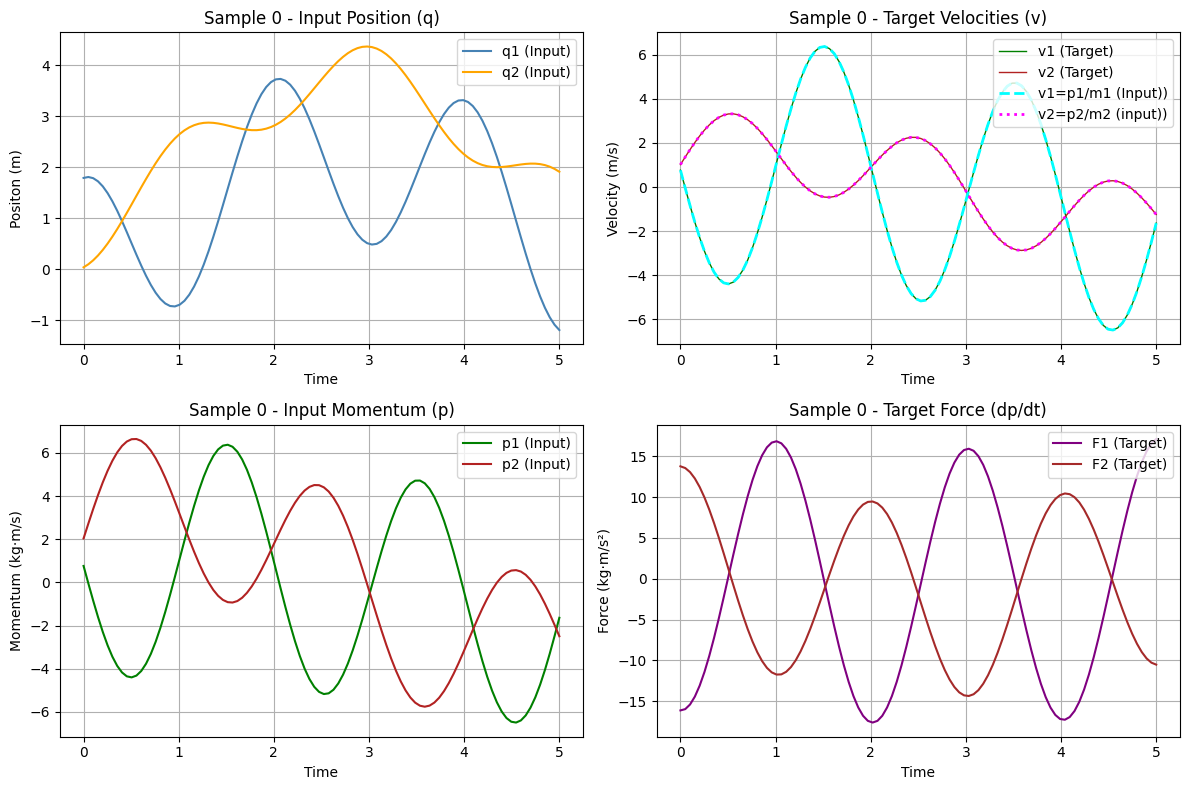

Sample 250 / 1000 processed.
x_input_original slice shape: (100, 4)
p1 shape after list conversion: (100,)


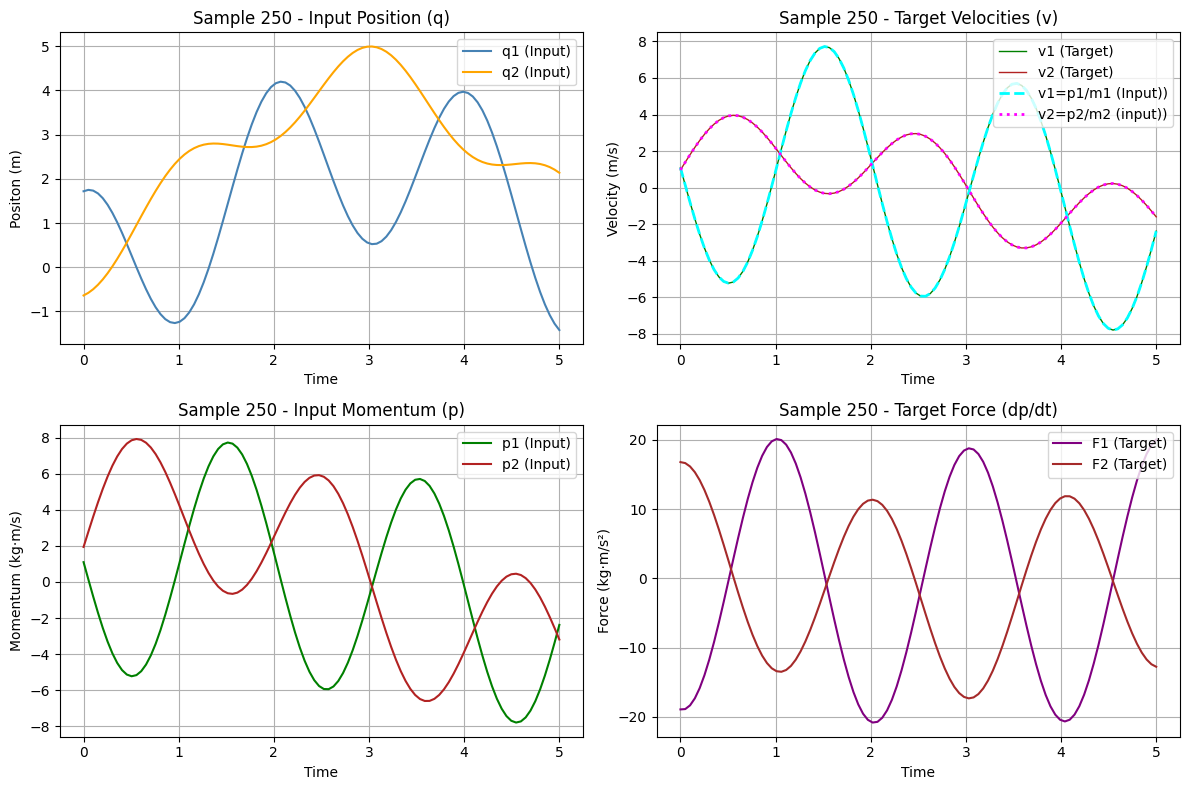

Sample 500 / 1000 processed.
x_input_original slice shape: (100, 4)
p1 shape after list conversion: (100,)


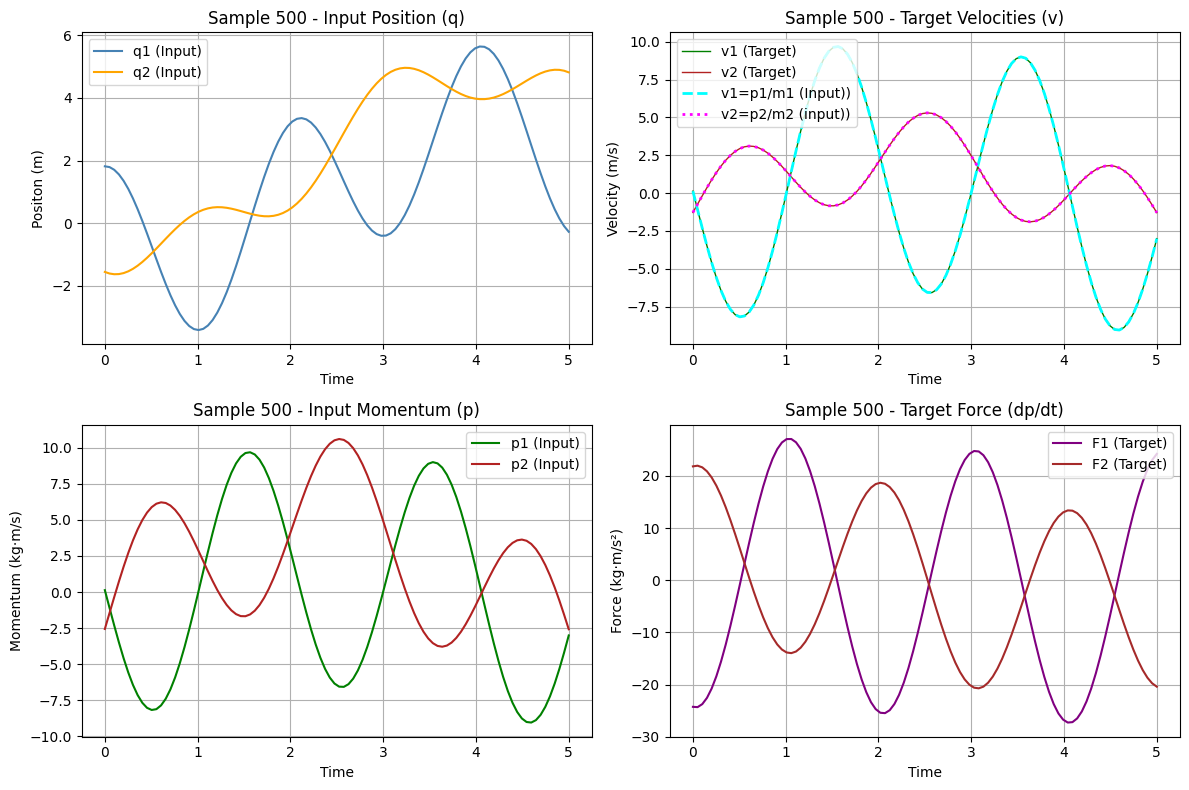

Sample 750 / 1000 processed.
x_input_original slice shape: (100, 4)
p1 shape after list conversion: (100,)


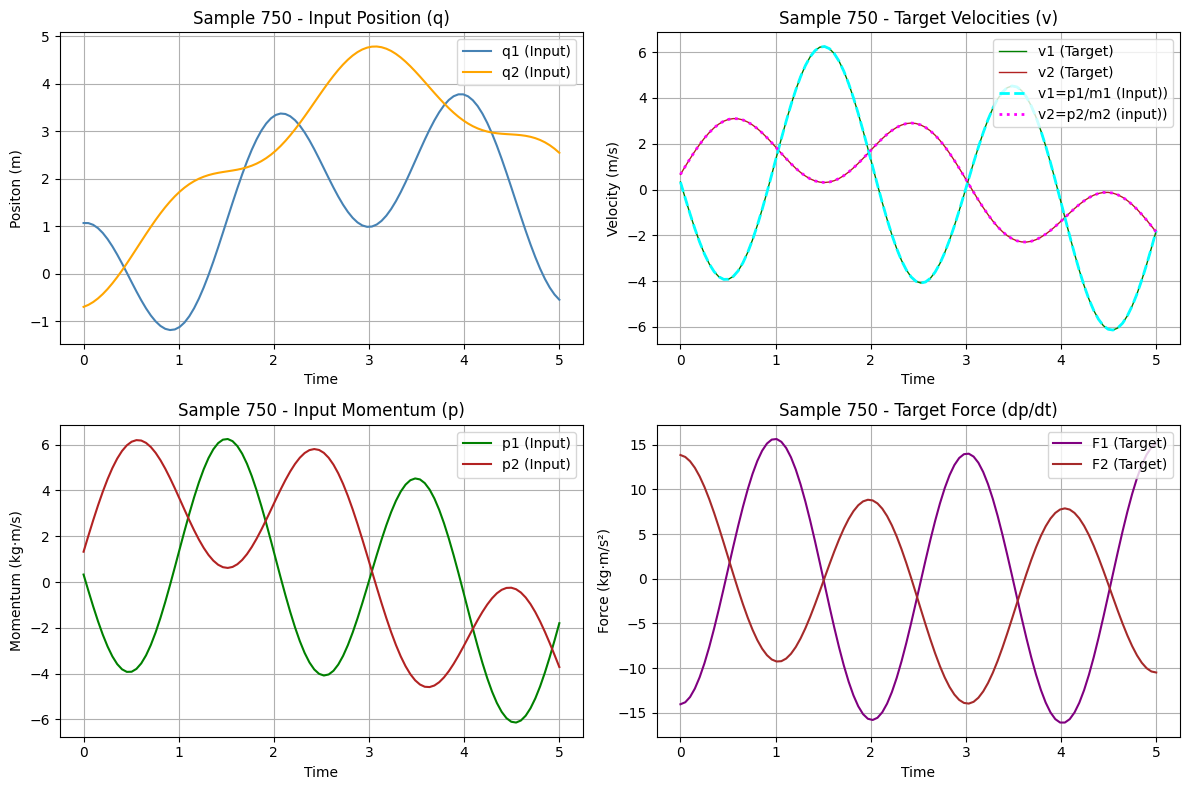

In [4]:
from matplotlib import pyplot as plt
import numpy as np

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]
num = 1000 # Number of samples of inital state vectors
x_input_original = B @ x_input_scaled.T
x_input_original = x_input_original.T
x_target_original = A @ x_target_scaled.T # Now B differs from A
x_target_original = x_target_original.T
print('x_input_original shape:', x_input_original.shape)
print('x_target_original shape:', x_target_original.shape) 

for i in range(num):
  if i % 250 == 0:
    print(f'Sample {i} / {num} processed.')
    print('x_input_original slice shape:', x_input_original[i*M:(i+1)*M, :].shape)

    data_slice = x_input_original[i*M:(i+1)*M, 0:1]
    
    q1 = np.array(data_slice.tolist()).reshape(-1)
    p1 = np.array(x_input_original[i*M:(i+1)*M, 2:3].tolist()).reshape(-1)
    q2 = np.array(x_input_original[i*M:(i+1)*M, 1:2].tolist()).reshape(-1)
    p2 = np.array(x_input_original[i*M:(i+1)*M, 3:4].tolist()).reshape(-1)
    
    print('p1 shape after list conversion:', p1.shape)

    V1, V2 = p1/m1, p2/m2
    
    plt.figure(figsize=(12, 8)) # 2x2 레이아웃

    # Subplot 1 (Top-Left): Input q1, q2
    plt.subplot(2, 2, 1)
    plt.title(f'Sample {i} - Input Position (q)')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 0], label='q1 (Input)', color='steelblue')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 1], label='q2 (Input)', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Positon (m)')
    plt.grid(True)
    plt.legend()

    # Subplot 2 (Top-Right): Target q derivative (i.e., dq1/dt, dq2/dt)
    plt.subplot(2, 2, 2)
    plt.title(f'Sample {i} - Target Velocities (v)')
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 0], label='v1 (Target)', color='g', lw=1)
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 1], label='v2 (Target)', color='firebrick', lw=1)
    # draw in dash/dot lines for comparison with v1, v2 converted from Input p1, p2.
    plt.plot(t_eval, V1, label='v1=p1/m1 (Input))', color='cyan', linestyle='--', lw=2)
    plt.plot(t_eval, V2, label='v2=p2/m2 (input))', color='magenta', linestyle=':', lw=2)
    plt.xlabel('Time')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()

    # Subplot 3 (Bottom-Left): Input p1, p2
    plt.subplot(2, 2, 3)
    plt.title(f'Sample {i} - Input Momentum (p)')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 2], label='p1 (Input)', color='g')
    plt.plot(t_eval, x_input_original[i*M:(i+1)*M, 3], label='p2 (Input)', color='firebrick')
    plt.xlabel('Time')
    plt.ylabel('Momentum (kg·m/s)')
    plt.grid(True)
    plt.legend()

    # Subplot 4 (Bottom-Right): Target p derivatives(ie., Force)
    plt.subplot(2, 2, 4)
    plt.title(f'Sample {i} - Target Force (dp/dt)')
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 2], label='F1 (Target)', color='purple')
    plt.plot(t_eval, x_target_original[i*M:(i+1)*M, 3], label='F2 (Target)', color='brown')
    plt.xlabel('Time')
    plt.ylabel('Force (kg·m/s²)')
    plt.grid(True)
    plt.legend()


    plt.tight_layout()
    plt.show()


Sample 0 / 1000 processed.
x_input_scaled slice shape: (100, 4)
p1 shape after list conversion: (100,)


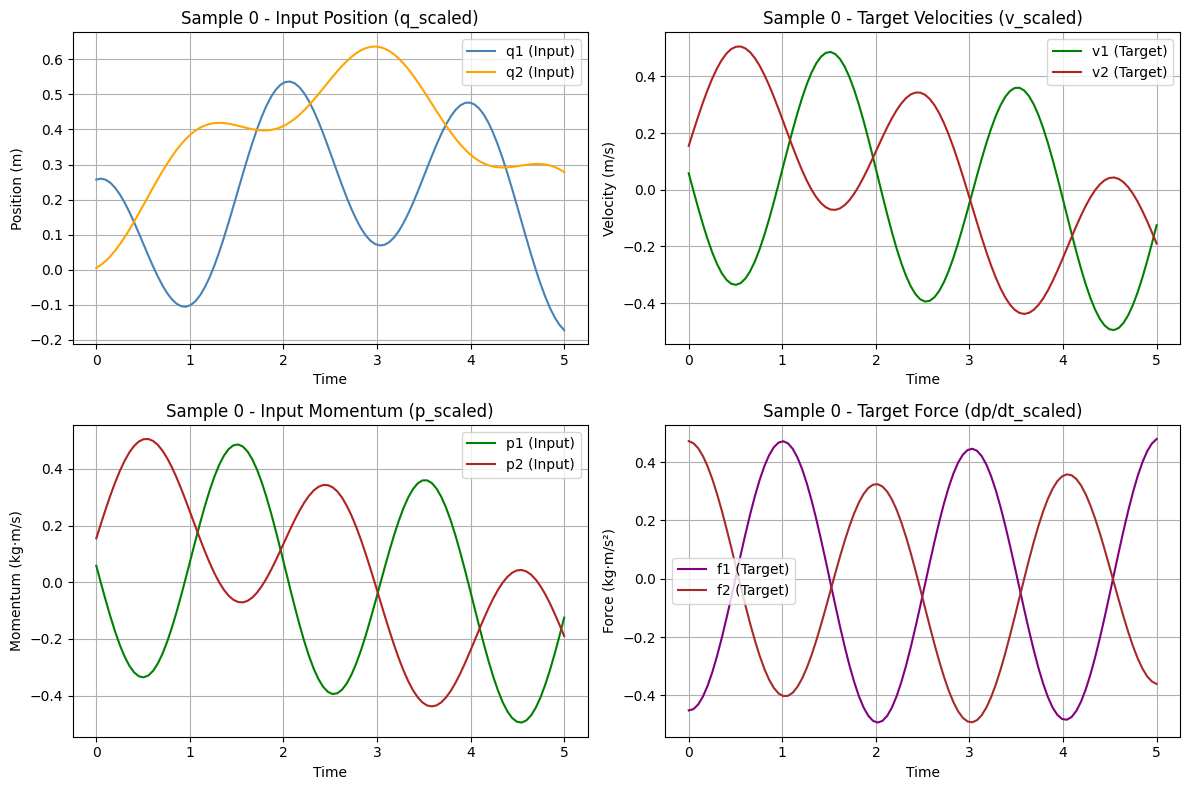

Sample 250 / 1000 processed.
x_input_scaled slice shape: (100, 4)
p1 shape after list conversion: (100,)


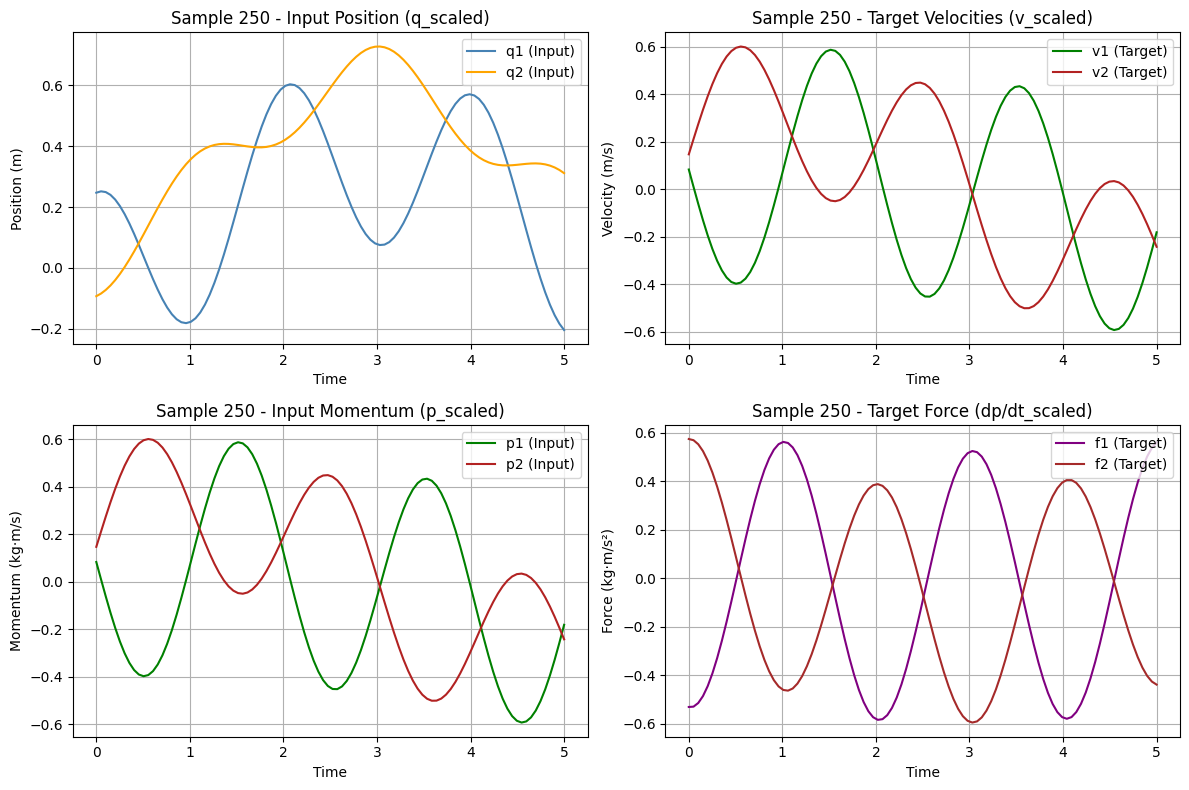

Sample 500 / 1000 processed.
x_input_scaled slice shape: (100, 4)
p1 shape after list conversion: (100,)


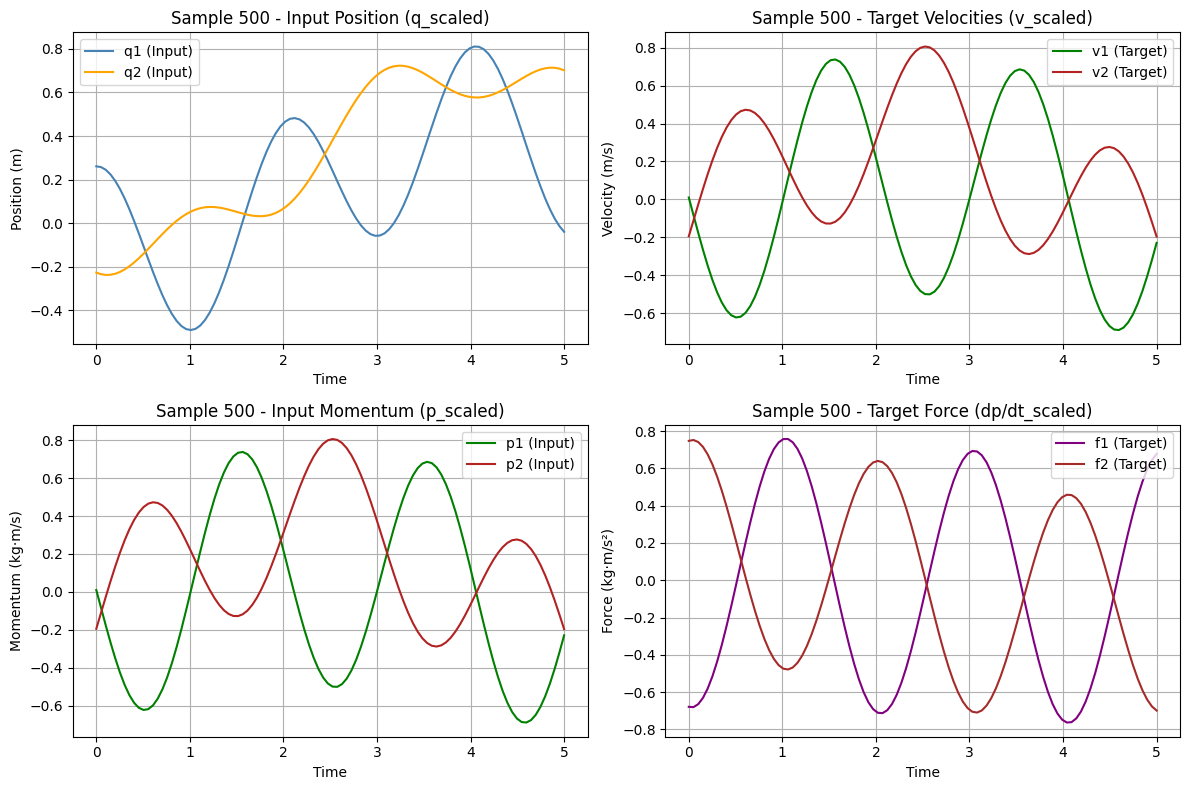

Sample 750 / 1000 processed.
x_input_scaled slice shape: (100, 4)
p1 shape after list conversion: (100,)


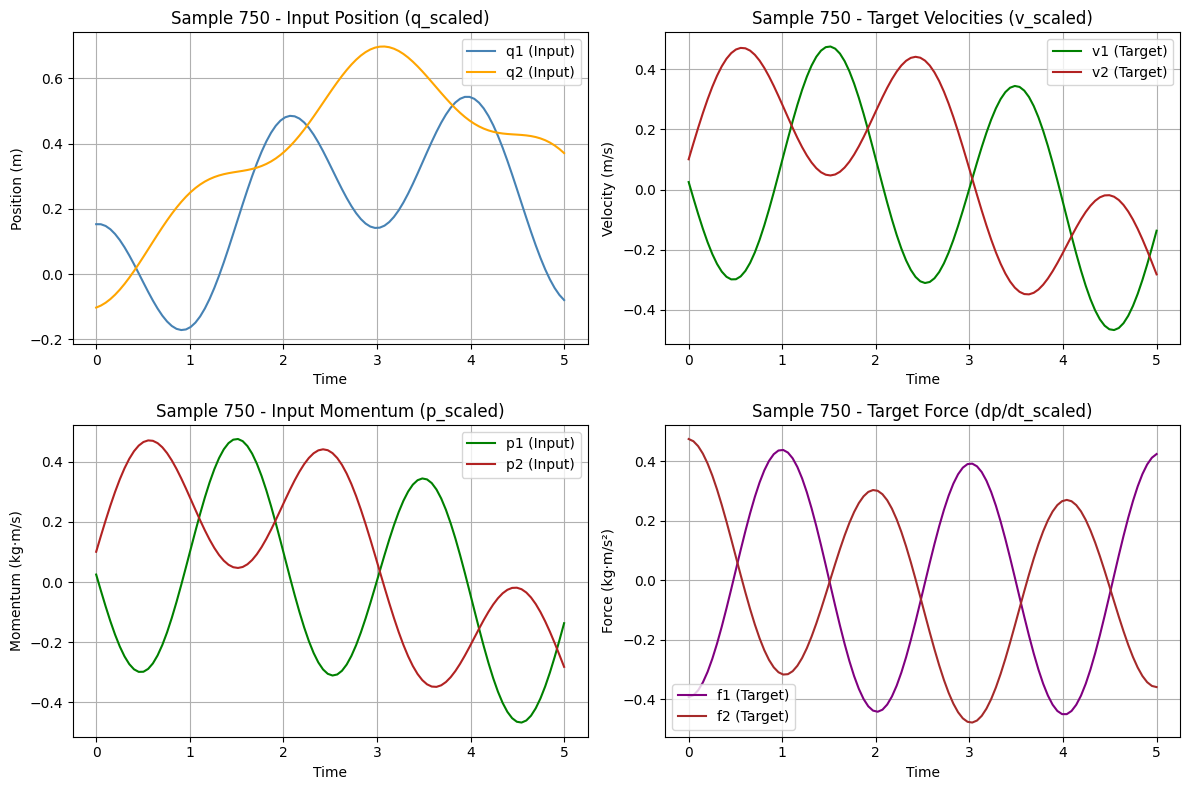

In [5]:
from matplotlib import pyplot as plt
import numpy as np

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval[1]-t_eval[0]
num = 1000 # number of samples for initial state vectors

for i in range(num):
  if i % 250 == 0:
    print(f'Sample {i} / {num} processed.')
    print('x_input_scaled slice shape:', x_input_scaled[i*M:(i+1)*M, :].shape)

    data_slice = x_input_original[i*M:(i+1)*M, 0:1]
    
    q1 = np.array(data_slice.tolist()).reshape(-1)
    p1 = np.array(x_input_scaled[i*M:(i+1)*M, 2:3].tolist()).reshape(-1)
    q2 = np.array(x_input_scaled[i*M:(i+1)*M, 1:2].tolist()).reshape(-1)
    p2 = np.array(x_input_scaled[i*M:(i+1)*M, 3:4].tolist()).reshape(-1)
    
    print('p1 shape after list conversion:', p1.shape)

    plt.figure(figsize=(12, 8)) # 2x2 layout

    # Subplot 1 (Top-Left): Input q1, q2
    plt.subplot(2, 2, 1)
    plt.title(f'Sample {i} - Input Position (q_scaled)')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 0], label='q1 (Input)', color='steelblue')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 1], label='q2 (Input)', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Position (m)')
    plt.grid(True)
    plt.legend()

    # Subplot 2 (Top-Right): Target q derivatives (i.e., dq1/dt, dq2/dt)
    plt.subplot(2, 2, 2)
    plt.title(f'Sample {i} - Target Velocities (v_scaled)')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 0], label='v1 (Target)', color='g')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 1], label='v2 (Target)', color='firebrick')
    plt.xlabel('Time')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True)
    plt.legend()


    # Subplot 3 (Bottom-Left): Input p1, p2
    plt.subplot(2, 2, 3)
    plt.title(f'Sample {i} - Input Momentum (p_scaled)')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 2], label='p1 (Input)', color='g')
    plt.plot(t_eval, x_input_scaled[i*M:(i+1)*M, 3], label='p2 (Input)', color='firebrick')
    plt.xlabel('Time')
    plt.ylabel('Momentum (kg·m/s)')
    plt.grid(True)
    plt.legend()

    # Subplot 4 (Bottom-Right): Target p derivatives (ie, dp/dt=f: Force)
    plt.subplot(2, 2, 4)
    plt.title(f'Sample {i} - Target Force (dp/dt_scaled)')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 2], label='f1 (Target)', color='purple')
    plt.plot(t_eval, x_target_scaled[i*M:(i+1)*M, 3], label='f2 (Target)', color='brown')
    plt.xlabel('Time')
    plt.ylabel('Force (kg·m/s²)')
    plt.grid(True)
    plt.legend()


    plt.tight_layout()
    plt.show()
